As an introduction to tensorflow, let's use tensorflow to classify MNIST numerals. However, we will not be using keras -- while keras simplifies constructing basic neural networks, it decreases flexibility that we may need in the future (e.g., when we try to model optical processes). I will try keep this introduction as simple as possible without including too many extra features that, while likely to be useful, may distract you from getting something running for the first time. Once we get the basics down, in the future we can revisit some of the helpful tools, such as graph visualization and tensorboard.

# import data

In [10]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label


(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


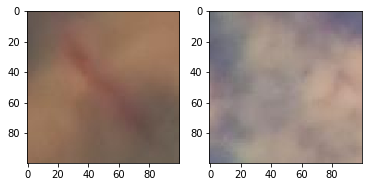

In [11]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.int)
X_val = X_val.astype(np.int)
y_train = y_train.astype(np.int)
y_val = y_val.astype(np.int)

# change into one-hot vector
y_train = tf.keras.utils.to_categorical(y_train, 2) 
y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);



In [12]:
def train_data(model, loss, val_loss):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                     batch_size=64,
                     epochs=50,  # Run thru all the data point in each epoch
                     verbose=1,
                     validation_data=(X_val, y_val),
                     #callbacks=[tensorboard])
                     callbacks=[early_stop, tensorboard])
    #val_err.append(hist.history['val_mean_absolute_error'][-1]) # a dict
    loss.append(hist.history['loss'][-1])
    val_loss.append(hist.history['val_loss'][-1])
    
    
    return loss, val_loss, hist

In [13]:
# Example CNN used in class
def VGG_cifar100(activ):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=activ, input_shape=(100, 100, 3)),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),
        
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),

        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.Conv2D(512, (3,3), padding='same', activation=activ),
        tf.keras.layers.MaxPool2D(padding='same'),


        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(4096, activation=activ),
        tf.keras.layers.Dense(1000, activation=activ),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
   

    model.summary()
    
    return model, param

In [14]:
def dnnmodel(n, activ, param):
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(100, 100, 3)))
    for i in range(n):
        model.add(tf.keras.layers.Dense(100, activation=activ))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    # model.summary()
    # model.count_params()
    param.append(model.count_params())
    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'mae'])
    return model, param

## VGG

In [15]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'relu'
model, param1 = VGG_cifar100(activ)
loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 256)       0         
__________

In [16]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'tanh'
model, param1 = VGG_cifar100(activ)

loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 25, 25, 256)       295168    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 25, 256)       590080    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 256)       0         
__________

## DNN

In [9]:
loss1 = []
val_loss1 =[]
param1 = []
activ = 'relu'
model, param1 = dnnmodel(15, activ, param1)
loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

Train on 7268 samples, validate on 808 samples
Epoch 1/50
7268/7268 [==============================] - 2s 281us/sample - loss: 6.9032 - acc: 0.5678 - mean_absolute_error: 0.4324 - val_loss: 7.1614 - val_acc: 0.5557 - val_mean_absolute_error: 0.4443
Epoch 2/50
7268/7268 [==============================] - 2s 238us/sample - loss: 6.9480 - acc: 0.5689 - mean_absolute_error: 0.4311 - val_loss: 7.1614 - val_acc: 0.5557 - val_mean_absolute_error: 0.4443
Epoch 3/50
7268/7268 [==============================] - 2s 237us/sample - loss: 6.9480 - acc: 0.5689 - mean_absolute_error: 0.4311 - val_loss: 7.1614 - val_acc: 0.5557 - val_mean_absolute_error: 0.4443
Epoch 4/50
7268/7268 [==============================] - 2s 238us/sample - loss: 6.9480 - acc: 0.5689 - mean_absolute_error: 0.4311 - val_loss: 7.1614 - val_acc: 0.5557 - val_mean_absolute_error: 0.4443


## ResNet

In [8]:
from tensorflow.keras.applications import ResNet50

def resnet():
    input_tensor = tf.keras.layers.Input(shape=(100, 100, 3))
    model = ResNet50(include_top=False, weights=None, input_tensor=input_tensor, input_shape=(100,100,3), pooling=None, classes=2)
    param = model.count_params()
    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model, param

In [9]:
loss1 = []
val_loss1 =[]
param1 = []
model, param = resnet()
loss1, val_loss1, hist1= train_data(model, loss1, val_loss1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

ValueError: A target array with shape (7268, 2) was passed for an output of shape (None, 4, 4, 2048) while using as loss `categorical_crossentropy`. This loss expects targets to have the same shape as the output.